# DisplacementMIP - Flood displacement impacts in the Horn of Africa

We model the annual average displacment (AAD) impacts and return periods curves for displaced people in the horn of Africa (Ethopia, Somalia, Sudan) for the displacmentMIP.

Data used:
* flood hazard maps from CIMA
* building exposure model (BEM) from [UNEP-GRID](https://giri.unepgrid.ch/sites/default/files/2023-09/GIRI_BEM_report_UNIGE.pdf)
* building level impact functions from two sources: a) [Englhardt et al., 2019](https://nhess.copernicus.org/articles/19/1703/2019/), b) CAPRA via CIMA

Set country (Ethopia, Somalia, Sudan (SDN)); note, we do not include South Sudan (SSD).

In [1]:
# hazard
CNTRY = 'SOMALIA'

In [2]:
# exposure
cntry_name = 'Somalia'

## Load Hazard (CIMA flood hazard)

Load the return period flood maps.

In [3]:
from climada.hazard import Hazard

In [4]:
import numpy as np
from pathlib import Path

In [5]:
HAZ_TYPE = 'FL'

In [6]:
HAZ_FOLDER = Path(f'/Users/simonameiler/Documents/WCR/Displacement/Somalia_CIMA_example/Hazard/{CNTRY}/HISTORICAL/')

In [7]:
haz_files = [str(file) for file in HAZ_FOLDER.glob('*.tif')]
rp = np.array([int(Path(file).stem[-4:]) for file in haz_files])

In [8]:
haz = Hazard.from_raster(
    haz_type=HAZ_TYPE, files_intensity=haz_files, src_crs='WGS84',
    attrs={'unit': 'm', 'event_id': np.arange(len(haz_files)), 'frequency':1/rp}
)

In [9]:
# convert intensity given in cm to m
haz.intensity = haz.intensity/100

In [10]:
haz.intensity.max(axis=1).data

array([5.56     , 6.8173584, 6.03     , 7.39     , 7.1      , 6.4      ,
       4.65     , 3.53     ])

## Load exposure (BEM)

Load Exposures

In [11]:
from climada.entity.exposures import Exposures

In [12]:
import os

os.chdir('/Users/simonameiler/Documents/WCR/Displacement/global-displacement-risk') # change back to root folder, not "~/doc"
import exposure
import vulnerability

In [13]:
exp_ivm = Exposures.from_hdf5(f'/Users/simonameiler/Documents/WCR/Displacement/global-displacement-risk/{cntry_name}_BEM_exp_IVM.hdf5')

In [14]:
exp_cima = Exposures.from_hdf5(f'/Users/simonameiler/Documents/WCR/Displacement/global-displacement-risk/{cntry_name}_BEM_exp_CIMA.hdf5')

<GeoAxes: >

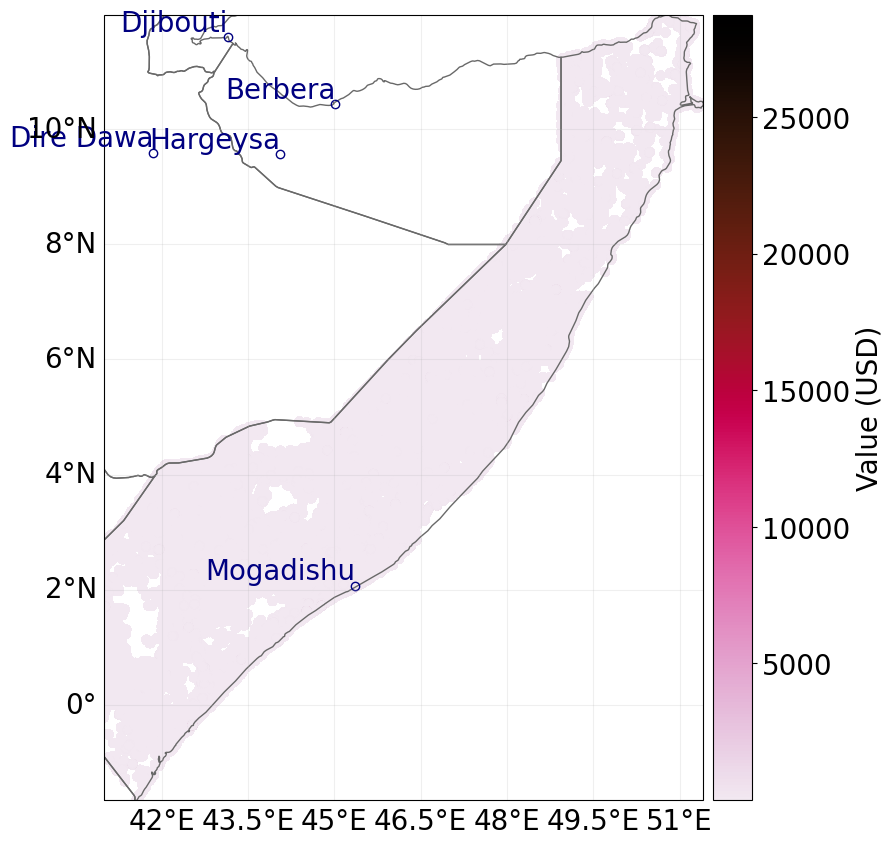

In [15]:
exp_ivm.plot_scatter()

In [18]:
print('Total population in exposure layer: ' + "{:,.0f}".format(exp_cima.gdf.value.sum()))

Total population in exposure layer: 14,134,633


In [19]:
exp_ivm.gdf.head()

,id_1x,cpx,value,bd_1_floor,bd_2_floor,bd_3_floor,geometry,impf_FL,longitude,latitude,index_right,0
6,194457751,3,0.003283,0.0,0.0,0.0,POINT (43.40417 0.66250),2,43.404167,0.6625,0,1
7,194457751,3,0.001404,0.0,0.0,0.0,POINT (43.40417 0.66250),2,43.404167,0.6625,0,1
12,194457751,3,0.002711,0.0,0.0,0.0,POINT (43.40417 0.66250),2,43.404167,0.6625,0,1
13,194457751,3,0.001159,0.0,0.0,0.0,POINT (43.40417 0.66250),2,43.404167,0.6625,0,1
18,194457751,3,0.281569,0.0,0.0,0.0,POINT (43.40417 0.66250),2,43.404167,0.6625,0,1


In [20]:
exp_cima.gdf.head()

,id_1x,cpx,value,geometry,impf_FL,longitude,latitude,index_right,0
6,194457751,3,0.003283,POINT (43.40417 0.66250),15,43.404167,0.6625,0,1
7,194457751,3,0.001404,POINT (43.40417 0.66250),14,43.404167,0.6625,0,1
12,194457751,3,0.002711,POINT (43.40417 0.66250),15,43.404167,0.6625,0,1
13,194457751,3,0.001159,POINT (43.40417 0.66250),14,43.404167,0.6625,0,1
18,194457751,3,0.281569,POINT (43.40417 0.66250),15,43.404167,0.6625,0,1


## Impact functions

#### IVM approach ([Englhardt et al., 2019](https://nhess.copernicus.org/articles/19/1703/2019/))

In [21]:
impf_set_ivm = vulnerability.IMPF_SET_FL_IVM

array([[<Axes: title={'center': 'FL 1: Flood impact function class I'}, xlabel='Intensity (metres)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 2: Flood impact function class II'}, xlabel='Intensity (metres)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 3: Flood impact function class III - one storey'}, xlabel='Intensity (metres)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'FL 5: Flood impact function class III - two storeys'}, xlabel='Intensity (metres)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 4: Flood impact function class IV - one storey'}, xlabel='Intensity (metres)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 6: Flood impact function class IV - two storeys'}, xlabel='Intensity (metres)', ylabel='Impact (%)'>]],
      dtype=object)

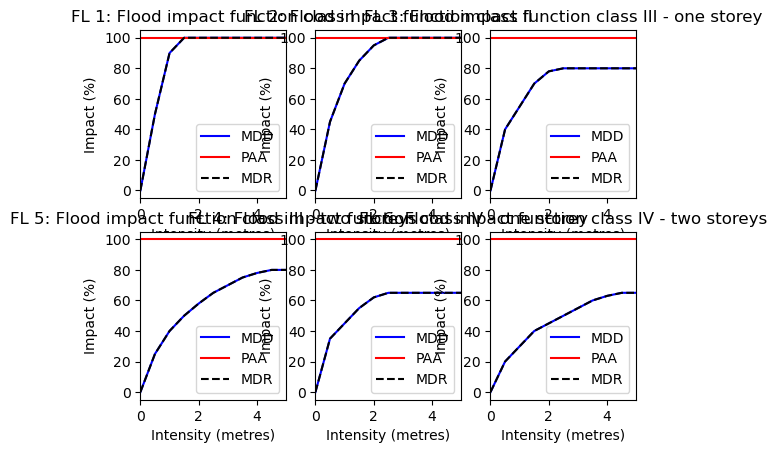

In [22]:
impf_set_ivm.plot()

Generate step function from PAGER building types

In [23]:
from climada.entity import ImpactFunc, ImpactFuncSet
impf_set_ivm_step = ImpactFuncSet()

In [24]:
# The threshold of building damage after which all people are displaced. Below, no-one is displaced.
building_thes = 0.55 # 55% iDMC v1; CIMA: 30% for Somalia to 60% for other countries. 

for imp_id in impf_set_ivm.get_ids(haz_type='FL'):
    impf_set_ivm.get_func(fun_id=imp_id)
    y = impf_set_ivm.get_func(fun_id=imp_id)[0].intensity
    x = impf_set_ivm.get_func(fun_id=imp_id)[0].mdd
    flood_thres = np.interp(building_thes, x, y)
    print('ID: '+str(imp_id)+' - threshold stepfunction: '+str(flood_thres))
    impf_set_ivm_step.append(
                ImpactFunc.from_step_impf(
                    intensity=(0,  flood_thres, flood_thres *10),
                    haz_type='FL',
                    impf_id=imp_id,
                    intensity_unit = 'm'
                )
    )

ID: 1 - threshold stepfunction: 0.5625
ID: 2 - threshold stepfunction: 0.7000000000000002
ID: 3 - threshold stepfunction: 1.0
ID: 5 - threshold stepfunction: 1.8125000000000004
ID: 4 - threshold stepfunction: 1.5
ID: 6 - threshold stepfunction: 3.0


array([[<Axes: title={'center': 'FL 1: '}, xlabel='Intensity (m)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 2: '}, xlabel='Intensity (m)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 3: '}, xlabel='Intensity (m)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'FL 5: '}, xlabel='Intensity (m)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 4: '}, xlabel='Intensity (m)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 6: '}, xlabel='Intensity (m)', ylabel='Impact (%)'>]],
      dtype=object)

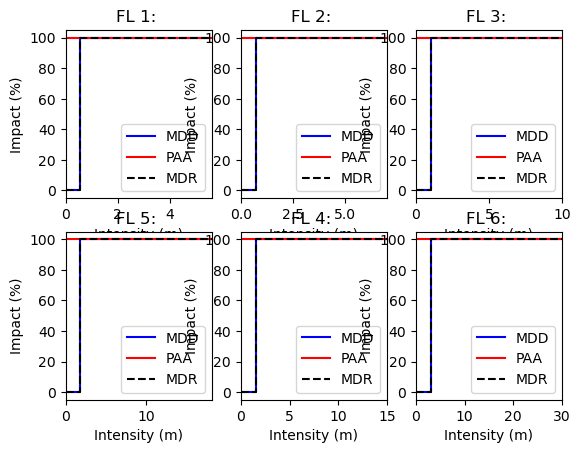

In [25]:
impf_set_ivm_step.plot()

#### CIMA-JRC approach

In [26]:
impf_set_cima = vulnerability.IMPF_SET_FL_CIMA

array([[<Axes: title={'center': 'FL 1: Flood impact function class C1'}, xlabel='Intensity (metres)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 2: Flood impact function C2'}, xlabel='Intensity (metres)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 3: Flood impact function C4'}, xlabel='Intensity (metres)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'FL 4: Flood impact function C5'}, xlabel='Intensity (metres)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 5: Flood impact function C30'}, xlabel='Intensity (metres)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 6: Flood impact function M1'}, xlabel='Intensity (metres)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'FL 7: Flood impact function M2'}, xlabel='Intensity (metres)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 8: Flood impact function M3'}, xlabel='Intensity (metres)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 9: Flood im

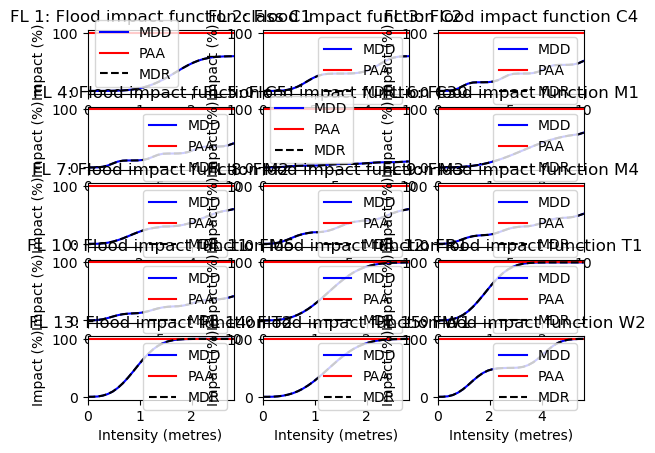

In [27]:
impf_set_cima.plot()

Generate step function from PAGER building types

In [28]:
from climada.entity import ImpactFunc, ImpactFuncSet
impf_set_cima_step = ImpactFuncSet()

In [52]:
# The threshold of building damage after which all people are displaced. Below, no-one is displaced.
building_thes = 0.3 # 55% iDMC v1; CIMA: 30% for Somalia to 60% for other countries. 

for imp_id in impf_set_cima.get_ids(haz_type='FL'):
    impf_set_cima.get_func(fun_id=imp_id)
    y = impf_set_cima.get_func(fun_id=imp_id)[0].intensity
    x = impf_set_cima.get_func(fun_id=imp_id)[0].mdd
    flood_thres = np.interp(building_thes, x, y)
    print('ID: '+str(imp_id)+' - threshold stepfunction: '+str(flood_thres))
    impf_set_cima_step.append(
                ImpactFunc.from_step_impf(
                    intensity=(0,  flood_thres, flood_thres *10),
                    haz_type='FL',
                    impf_id=imp_id,
                    intensity_unit = 'm'
                )
    )

ID: 1 - threshold stepfunction: 1.6501727272727271
ID: 2 - threshold stepfunction: 3.0897
ID: 3 - threshold stepfunction: 5.8621
ID: 4 - threshold stepfunction: 7.25308813559322
ID: 5 - threshold stepfunction: 10.0
ID: 6 - threshold stepfunction: 1.6494416666666667
ID: 7 - threshold stepfunction: 2.8966
ID: 8 - threshold stepfunction: 4.4510233333333336
ID: 9 - threshold stepfunction: 5.833358333333334
ID: 10 - threshold stepfunction: 7.2498097560975605
ID: 11 - threshold stepfunction: 1.0249714285714286
ID: 12 - threshold stepfunction: 0.7434042553191489
ID: 13 - threshold stepfunction: 0.7436553191489361
ID: 14 - threshold stepfunction: 1.0249714285714286
ID: 15 - threshold stepfunction: 1.4075205479452055


array([[<Axes: title={'center': 'FL 1: '}, xlabel='Intensity (m)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 2: '}, xlabel='Intensity (m)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 3: '}, xlabel='Intensity (m)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'FL 4: '}, xlabel='Intensity (m)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 5: '}, xlabel='Intensity (m)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 6: '}, xlabel='Intensity (m)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'FL 7: '}, xlabel='Intensity (m)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 8: '}, xlabel='Intensity (m)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 9: '}, xlabel='Intensity (m)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'FL 10: '}, xlabel='Intensity (m)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 11: '}, xlabel='Intensity (m)', ylabel='Impact (%)'>,
        <Axes: t

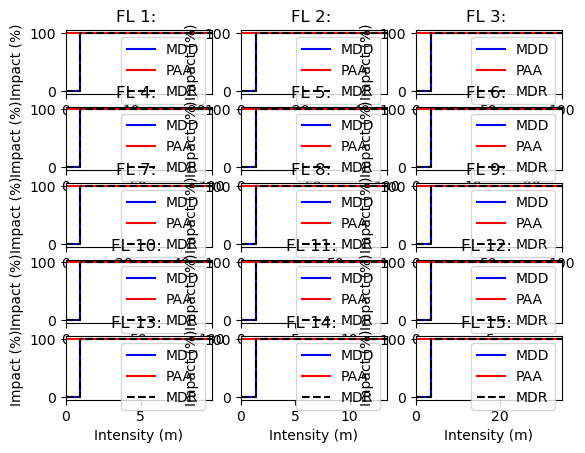

In [30]:
impf_set_cima_step.plot()

### Impacts

#### Historical

In [31]:
from climada.engine import ImpactCalc

In [32]:
impcalc = ImpactCalc(exp_ivm, impf_set_ivm_step, haz)
impact_ivm = impcalc.impact()

In [53]:
impcalc = ImpactCalc(exp_cima, impf_set_cima_step, haz)
impact_cima = impcalc.impact()

In [34]:
print('Annual average displacement - IVM: ' + "{:,.0f}".format(impact_ivm.aai_agg))
print('Annual average displacement - CIMA/JRC: ' + "{:,.0f}".format(impact_cima.aai_agg))

Annual average displacement - IVM: 106,563
Annual average displacement - CIMA/JRC: 19,203


In [35]:
freqd_curve_ivm = impact_ivm.calc_freq_curve(return_per = np.arange(1, 250, 1))
freqd_curve_cima = impact_cima.calc_freq_curve(return_per = np.arange(1, 250, 1))

In [36]:
fq_dict = {'IVM': freqd_curve_ivm,
           'CIMA': freqd_curve_cima}

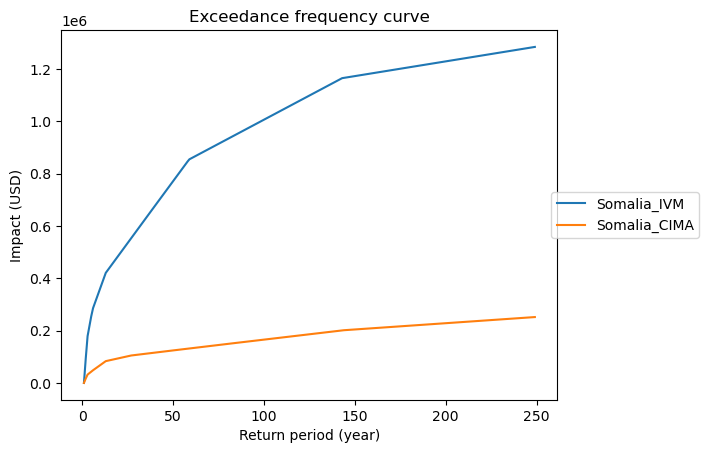

In [37]:
import matplotlib.pyplot as plt

labels = list(fq_dict.keys())

fig, axis = plt.subplots()

for i, (plots, fq) in enumerate(fq_dict.items()):
    fq.plot(axis=axis, label=str(cntry_name)+'_'+labels[i])

axis.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))
#axis.set_title('Exceedance frequency curve: '+str(cntry_name))

#### Probable maximum displacement (PMD) - Impact for given RPs

## "Validation" - comparison to iDMC database

In [38]:
import os
import pandas as pd

os.chdir('/Users/simonameiler/Documents/WCR/Displacement/global-displacement-risk') # change back to root folder, not "~/doc"
import validation

In [39]:
file_path = 'data/IDMC_GIDD_Disasters_Internal_Displacement_Data.xlsx'
idmc_df = df = pd.read_excel(file_path, sheet_name='1_Disaster_Displacement_data')

In [40]:
from climada.util import coordinates as u_coords
cntry_iso = u_coords.country_to_iso(cntry_name)

In [41]:
mean = validation.extract_idmc_data(df, iso3=cntry_iso, hazard_sub_type='Flood', calculation='mean')

In [42]:
mean_2017 = validation.extract_idmc_data(df, iso3=cntry_iso, hazard_sub_type='Flood', calculation='mean', start_year=2017, end_year=None)

In [43]:
print('Reported average annual displacement - '+str(cntry_name)+': ' + "{:,.0f}".format(mean))

Reported average annual displacement - Somalia: 184,921


In [44]:
print('Reported average annual displacement 2017 onwards - '+str(cntry_name)+': ' + "{:,.0f}".format(mean_2017))

Reported average annual displacement 2017 onwards - Somalia: 360,039


## "Validation" - comparison to simple approach

Use the Global Human Settlement Layer (GHSL) for exposure and a 0.5 m and 1.0 m step function ([Kam et al., 2021](https://iopscience.iop.org/article/10.1088/1748-9326/abd26c)) for comparison.

In [45]:
exp_ghsl = exposure.exp_from_ghsl(cntry_name)

In [46]:
exp_ghsl.gdf["impf_FL"] = 1

In [47]:
exp_ghsl.gdf.head()

,longitude,latitude,value,geometry,impf_FL
0,40.966194,11.992546,0.0,POINT (40.96619 11.99255),1
1,40.976155,11.992546,0.0,POINT (40.97616 11.99255),1
2,40.986117,11.992546,0.0,POINT (40.98612 11.99255),1
3,40.996079,11.992546,0.0,POINT (40.99608 11.99255),1
4,41.006041,11.992546,0.0,POINT (41.00604 11.99255),1


In [48]:
print('Total population in GHSL exposure layer: ' + "{:,.0f}".format(exp_ghsl.gdf.value.sum()))

Total population in GHSL exposure layer: 10,459,415


Choose threshold for step function below

In [49]:
from climada.entity import ImpactFunc, ImpactFuncSet
thresh = 0.5 # set threshold flood depth for displacement
impf_step = ImpactFunc.from_step_impf(intensity=(0, thresh, 20), haz_type='FL', impf_id=1)
imp_fun_set = ImpactFuncSet([impf_step])

<Axes: title={'center': 'FL 1: '}, xlabel='Intensity ()', ylabel='Impact (%)'>

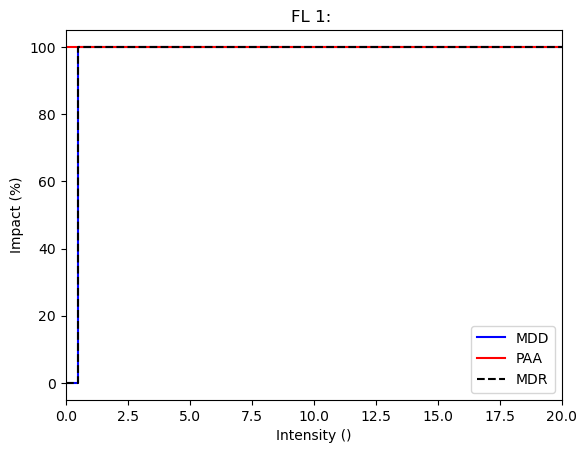

In [50]:
imp_fun_set.plot()

In [51]:
impcalc = ImpactCalc(exp_ghsl, imp_fun_set, haz)
impact_simple = impcalc.impact()

KeyboardInterrupt: 

In [ ]:
print('Annual average displacement: ' + "{:,.0f}".format(impact_simple.aai_agg))